  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


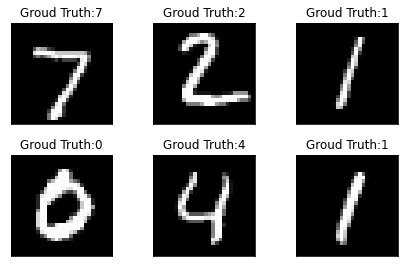

In [5]:
import matplotlib
import numpy as np
import torch

# 导入pytorch内置的mnist数据
from torchvision.datasets import mnist

# 导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn


# 2.定义一些超参数
train_batch_size = 64
test_batch_size = 64
learning_rate = 0.01
num_epoches = 20
lr = 0.01
momentum = 0.5


# 3.下载数据预处理
# 定义预处理函数，这些预处理依次放在Compose函数中。
# 1）transforms.Compose可以把一些转换函数组会在一起
# 2）Normalize([0,0.5],[0,0.5])对张量归一化，两个0.5分别表示对张量进行归一化的全局平均值核方差。
# 3）download参数控制是否需要下载，若./data目录下已有MNIST，选择False
# 4）用DataLoader得到生成器看，节省内存。
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
#  下载数据，并对数据做预处理
train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)
# dataloader是一个可迭代对象，可以使用迭代器一样使用。
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# 3.可视化源数据
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
batch_idx, (examples_data, examples_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(examples_data[i][0], cmap='gray', interpolation='none')
    plt.title('Groud Truth:{}'.format(examples_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [6]:
# 4.构建模型
# 4.1 构建网络
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential()函数功能将网络的层组合到一起
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x



In [7]:
# 4.2 实例化网络
# 检测是否有可用GPU，有则使用，否则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 实例化网络
model = Net(28 * 28, 300, 100, 10)
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# 5.训练模型
# 包括对训练数据的训练模型，然后用测试数据的验证模型
# 5.1 训练模型
losses=[]
acces=[]
eval_losses=[]
eval_acces=[]
for epoch in range(num_epoches):
  train_loss=0
  train_acc=0
  model.train()
  # 动态修改参数学习率
  if epoch%5==0:
    optimizer.param_groups[0]['lr']*=0.1
  for img,label in train_loader:
    img=img.to(device)
    label=label.to(device)
    img=img.view(img.size(0),-1)
    # 前向传播
    out=model(img)
    loss=criterion(out,label)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 记录误差
    train_loss+=loss.item()
    # 计算分类的准确率
    _,pred=out.max(1)
    num_corrent=(pred==label).sum().item()
    acc=num_corrent/img.shape[0]
    train_acc+=acc

  losses.append(train_loss/len(train_loader))
  acces.append(train_acc/len(train_loader))

  # 在测试集上检验效果
  eval_loss=0
  eval_acc=0
  # 将模式改为预测模式
  model.eval()
  for img,label in test_loader:
    img=img.to(device)
    label=label.to(device)
    img=img.view(img.size(0),-1)
    out=model(img)
    loss=criterion(out,label)
    # 记录误差
    eval_loss+=loss.item()
    # 计算准确率
    _,pred=out.max(1)
    num_corrent=(pred==label).sum().item()
    acc=num_corrent/img.shape[0]
    eval_acc+=acc
  eval_losses.append(eval_loss/len(test_loader))
  eval_acces.append(eval_acc/len(test_loader))
  print('epoch: {},Train Loss: {:.4f},Train Acc: {:.4f},Test Loss:{:.4f},Test Acc:{:.4f}'.format(epoch,train_loss/len(train_loader),train_acc/len(train_loader),eval_loss/len(test_loader),eval_acc/len(test_loader)))


epoch: 0,Train Loss: 1.0339,Train Acc: 0.7828,Test Loss:0.5562,Test Acc:0.9004
epoch: 1,Train Loss: 0.4821,Train Acc: 0.8995,Test Loss:0.3499,Test Acc:0.9257
epoch: 2,Train Loss: 0.3490,Train Acc: 0.9193,Test Loss:0.2701,Test Acc:0.9389
epoch: 3,Train Loss: 0.2827,Train Acc: 0.9319,Test Loss:0.2250,Test Acc:0.9465
epoch: 4,Train Loss: 0.2403,Train Acc: 0.9417,Test Loss:0.1965,Test Acc:0.9529
epoch: 5,Train Loss: 0.2214,Train Acc: 0.9456,Test Loss:0.1970,Test Acc:0.9526
epoch: 6,Train Loss: 0.2178,Train Acc: 0.9472,Test Loss:0.1912,Test Acc:0.9522
epoch: 7,Train Loss: 0.2138,Train Acc: 0.9475,Test Loss:0.1896,Test Acc:0.9532
epoch: 8,Train Loss: 0.2115,Train Acc: 0.9482,Test Loss:0.1857,Test Acc:0.9553
epoch: 9,Train Loss: 0.2073,Train Acc: 0.9495,Test Loss:0.1846,Test Acc:0.9546
epoch: 10,Train Loss: 0.2063,Train Acc: 0.9487,Test Loss:0.1843,Test Acc:0.9560
epoch: 11,Train Loss: 0.2053,Train Acc: 0.9502,Test Loss:0.1833,Test Acc:0.9547
epoch: 12,Train Loss: 0.2058,Train Acc: 0.9503,Tes

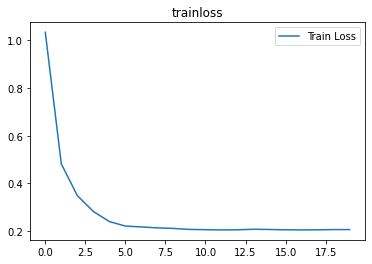

In [11]:
plt.title('trainloss')
plt.plot(np.arange(len(losses)),losses)
plt.legend(['Train Loss'],loc='upper right')